In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

from scipy import signal
from scipy.signal import find_peaks
from scipy.integrate import cumtrapz

from datetime import datetime

import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import sqlite3

import math

In [3]:
# サンプリングレート(0.015秒に1回)
sampling_rate = 66

filter_num = sampling_rate * 1

In [4]:
class Data:
    def __init__(self, folder_name):
        self.folder_name = "data/" + folder_name
        self.path = folder_name
        self.file_names = os.listdir(self.folder_name)

        self.start_time = None
        self.end_time = None

        # acceleration.csvがない場合は作成する
        if "acceleration.csv" not in self.file_names:
            self.make_acceleration()
            self.file_names = os.listdir(self.folder_name)

        # 'all.csv'がある場合は削除する
        if "all.csv" in self.file_names:
            self.file_names.remove("all.csv")

        self.df = pd.DataFrame()
        for file_name in self.file_names:
            df_tmp = pd.read_csv(os.path.join(self.folder_name, file_name))
            file_type = file_name.replace(".csv", "")

            # 列名を変更してファイル名を追加
            df_tmp = df_tmp.rename(
                columns={
                    "x": file_type + "_x",
                    "y": file_type + "_y",
                    "z": file_type + "_z",
                }
            )

            # 'rotate.csv' に 'w' 列がある場合は削除
            if "w" in df_tmp.columns and file_name == "rotate.csv":
                df_tmp = df_tmp.drop(["w"], axis=1)

            if type(df_tmp["time"][0]) == int:
                # 'time'列の変換を実行
                df_tmp["time"] = df_tmp["time"] / 1000
                df_tmp["time"] = pd.to_datetime(df_tmp["time"], unit="s")

            # df_tmpをdfに追記する,既にある列名は追記しない
            self.df = pd.concat([self.df, df_tmp], axis=1, sort=False)

            # 呼び出したファイルに上書き保存する
            df_tmp.to_csv(os.path.join(self.folder_name, file_name), index=False)

        # 1行目のtime列以外のtime列を削除する
        self.df = self.df.iloc[
            :,
            [0]
            + [
                i
                for i in range(1, len(self.df.columns))
                if not self.df.columns[i].startswith("time")
            ],
        ]
        self.df["time"] = pd.to_datetime(self.df["time"] / 1000, unit="s")

        # csvファイルを出力する
        self.df.to_csv(os.path.join(self.folder_name, "all.csv"), index=False)

    def make_acceleration(self):
        df_tmp = pd.read_csv(os.path.join(self.folder_name, "velocity.csv"))
        df_acc = df_tmp
        # df_tmpからx,y,z列を削除する
        df_acc = df_acc.drop(["x", "y", "z"], axis=1)
        df_acc["x"] = df_tmp["x"].cumsum()
        df_acc["y"] = df_tmp["y"].cumsum()
        df_acc["z"] = df_tmp["z"].cumsum()
        df_acc.to_csv(os.path.join(self.folder_name, "acceleration.csv"), index=False)
        df_acc = df_acc.drop(["time"], axis=1)
        df_acc["acceleration_x"] = df_acc["x"]
        df_acc["acceleration_y"] = df_acc["y"]
        df_acc["acceleration_z"] = df_acc["z"]
        df_acc = df_acc.drop(["x", "y", "z"], axis=1)
        self.df = pd.concat([self.df, df_acc], axis=1, sort=False)
        return self

    def low_filter(self, column_type, n):
        if column_type == "all":
            for column in self.file_names:
                column = column.replace(".csv", "")
                if column == "all":
                    pass
                self.low_filter(column, n)
        else:
            column = column_type + "_x"
            out_column = column_type + "_low_x"
            self.df[out_column] = self.df[column].rolling(n, center=True).mean()
            column = column_type + "_y"
            out_column = column_type + "_low_y"
            self.df[out_column] = self.df[column].rolling(n, center=True).mean()
            column = column_type + "_z"
            out_column = column_type + "_low_z"
            self.df[out_column] = self.df[column].rolling(n, center=True).mean()
        return self

    def high_filter(self, column_type, n):
        if column_type == "all":
            for column in self.file_names:
                column = column.replace(".csv", "")
                if column == "all":
                    pass
                self.high_filter(column, n)
        else:
            column = column_type + "_x"
            out_column = column_type + "_high_x"
            self.df[out_column] = (
                self.df[column] - self.df[column].rolling(n, center=False).mean()
            )
            column = column_type + "_y"
            out_column = column_type + "_high_y"
            self.df[out_column] = (
                self.df[column] - self.df[column].rolling(n, center=False).mean()
            )
            column = column_type + "_z"
            out_column = column_type + "_high_z"
            self.df[out_column] = (
                self.df[column] - self.df[column].rolling(n, center=False).mean()
            )
        return self

    def diff(self, column_type):
        if column_type == "all":
            for column in self.file_names:
                column = column.replace(".csv", "")
                if column == "all":
                    pass
                self.diff(column)
        else:
            column = column_type + "_x"
            out_column = column_type + "_diff_x"
            self.df[out_column] = self.df[column].diff()
            column = column_type + "_y"
            out_column = column_type + "_diff_y"
            self.df[out_column] = self.df[column].diff()
            column = column_type + "_z"
            out_column = column_type + "_diff_z"
            self.df[out_column] = self.df[column].diff()
        return self

    def reverse(self, column_type):
        if column_type == "all":
            for column in self.file_names:
                column = column.replace(".csv", "")
                if column == "all":
                    pass
                self.reverse(column)
        else:
            column = column_type + "_x"
            out_column = column_type + "_reverse_x"
            self.df[out_column] = self.df[column] * -1
            column = column_type + "_y"
            out_column = column_type + "_reverse_y"
            self.df[out_column] = self.df[column] * -1
            column = column_type + "_z"
            out_column = column_type + "_reverse_z"
            self.df[out_column] = self.df[column] * -1
        return self

    def non_minus(self, column_type):
        if column_type == "all":
            for column in self.file_names:
                column = column.replace(".csv", "")
                if column == "all":
                    pass
                self.non_minus(column)
        else:
            column = column_type + "_x"
            out_column = column_type + "_non_minus_x"
            self.df[out_column] = [x * -1 if x < 0 else x for x in self.df[column]]
            column = column_type + "_y"
            out_column = column_type + "_non_minus_y"
            self.df[out_column] = [x * -1 if x < 0 else x for x in self.df[column]]
            column = column_type + "_z"
            out_column = column_type + "_non_minus_z"
            self.df[out_column] = [x * -1 if x < 0 else x for x in self.df[column]]
        return self

    def shift_minus(self, column_type):
        if column_type == "all":
            for column in self.file_names:
                column = column.replace(".csv", "")
                if column == "all":
                    pass
                self.shift_minus(column)
        else:
            column = column_type + "_x"
            out_column = column_type + "_shift_minus_x"
            self.df[out_column] = self.df[column].apply(lambda x: 0 if x < 0 else x)
            column = column_type + "_y"
            out_column = column_type + "_shift_minus_y"
            self.df[out_column] = self.df[column].apply(lambda x: 0 if x < 0 else x)
            column = column_type + "_z"
            out_column = column_type + "_shift_minus_z"
            self.df[out_column] = self.df[column].apply(lambda x: 0 if x < 0 else x)
        return self

    def cumsum(self, column_type):
        if column_type == "all":
            for column in self.file_names:
                column = column.replace(".csv", "")
                if column == "all":
                    pass
                self.cumsum(column)
        else:
            column_x = column_type + "_x"
            out_column_x = column_type + "_cumsum_x"
            self.df[out_column_x] = self.df[column_x].cumsum()
            column_y = column_type + "_y"
            out_column_y = column_type + "_cumsum_y"
            self.df[out_column_y] = self.df[column_y].cumsum()
            column_z = column_type + "_z"
            out_column_z = column_type + "_cumsum_z"
            self.df[out_column_z] = self.df[column_z].cumsum()
        return self

    def plot(self, column_type, option, axis):
        self.i = 0
        self.fig = plt.figure(figsize=(15, 25))

        if column_type == "all":
            # 'all.csv'がある場合は削除する
            for column in self.file_names:
                column = column.replace(".csv", "")
                if column == "all":
                    continue
                self.ax(column, option, axis)
                self.i += 1
        else:
            column_type = column_type.replace(".csv", "")
            self.ax(column_type, option, axis)
        plt.show()

    def ax(self, column_type, option, axis):
        self.low_filter(column_type, filter_num)
        ax = self.fig.add_subplot(5, 1, self.i + 1)
        match option:
            case "axvspan":
                self.axvspan(column_type)
            case "diff":
                column_type = column_type + "_diff"
            case "high":
                column_type = column_type + "_high"
            case "low":
                column_type = column_type + "_low"
            case "reverse":
                column_type = column_type + "_reverse"
            case "shift_minus":
                column_type = column_type + "_shift_minus"
            case "reverse":
                column_type = column_type + "_reverse"
            case "non_minus":
                column_type = column_type + "_non_minus"
            case "cumsum":
                column_type = column_type + "_cumsum"
        match axis:
            case "x":
                ax.plot(
                    self.df["time"],
                    self.df[column_type + "_x"],
                    label=column_type + "_x",
                )
            case "y":
                ax.plot(
                    self.df["time"],
                    self.df[column_type + "_y"],
                    label=column_type + "_y",
                )
            case "z":
                ax.plot(
                    self.df["time"],
                    self.df[column_type + "_z"],
                    label=column_type + "_z",
                )
            case _:
                ax.plot(
                    self.df["time"],
                    self.df[column_type + "_x"],
                    label=column_type + "_x",
                )
                ax.plot(
                    self.df["time"],
                    self.df[column_type + "_y"],
                    label=column_type + "_y",
                )
                ax.plot(
                    self.df["time"],
                    self.df[column_type + "_z"],
                    label=column_type + "_z",
                )
        ax.legend()
        # タイトル
        ax.set_title(column_type)
        ax.set_xlabel("time")
        ax.set_ylabel(column_type)
        ax.grid()

    def axvspan(self, column_type):
        ax.axvspan(self.start_time, self.end_time, color="red", alpha=0.5)

    def split_time(self, start_time, end_time):
        self.df = self.df[
            (self.df["time"] >= start_time) & (self.df["time"] <= end_time)
        ]
        return self

In [5]:
# free_walkのデータを読み込む
free_walk = Data("free_walk")
free_walk.low_filter("all", filter_num)

## 階段登ってるかの判別


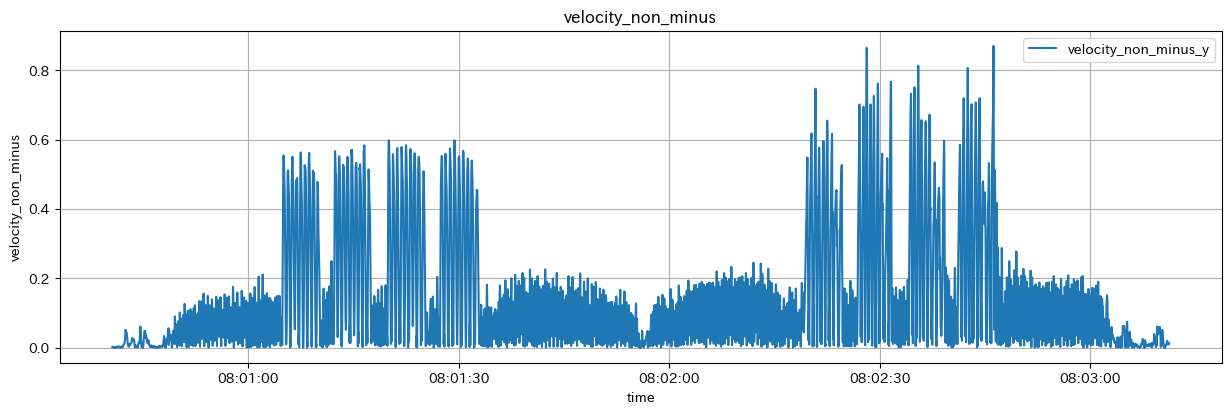

In [6]:
free_walk.non_minus("velocity")
free_walk.plot("velocity", "non_minus", "y")

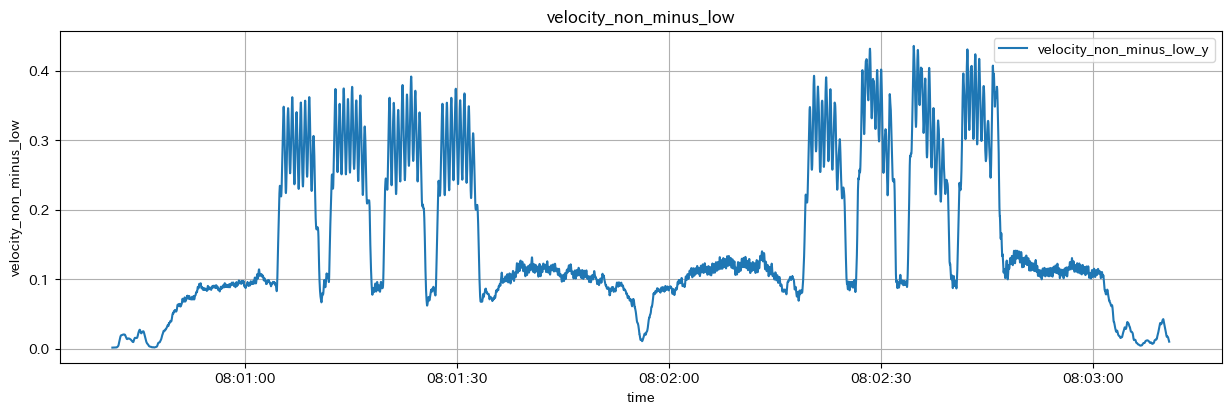

In [7]:
free_walk.low_filter("velocity_non_minus", filter_num)
free_walk.plot("velocity_non_minus", "low", "y")

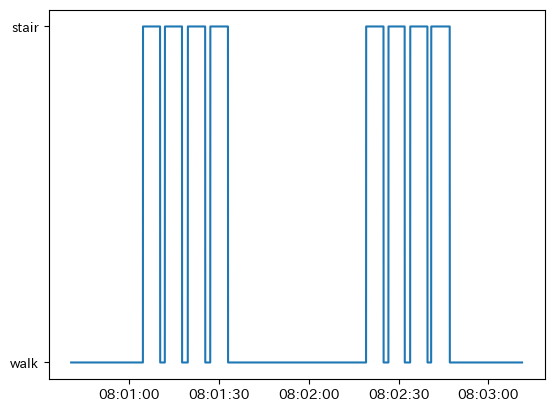

In [8]:
# ['velocity_non_minus_low_y'] > 0.2 のときは status を 'stair'にするそれ以外は 'walk'にする
free_walk.df["status"] = free_walk.df["velocity_non_minus_low_y"].apply(
    lambda x: "stair" if x > 0.15 else "walk"
)
# plot
plt.plot(free_walk.df["time"], free_walk.df["status"])
plt.show()

## walk から stair に切り替わるときと、stair から walk に切り替わるときの position_y を比較する


In [9]:
# walk → stair のインデックスを取得
walk_to_stair = free_walk.df[
    (free_walk.df["status"] == "stair") & (free_walk.df["status"].shift() == "walk")
].index
print(walk_to_stair)
# 時間に変化
walk_to_stair_time = free_walk.df["time"][walk_to_stair]
print(walk_to_stair_time)

# stair → walk のインデックスを取得
stair_to_walk = free_walk.df[
    (free_walk.df["status"] == "walk") & (free_walk.df["status"].shift() == "stair")
].index
print(stair_to_walk)
# 時間に変化
stair_to_walk_time = free_walk.df["time"][stair_to_walk]
print(stair_to_walk_time)

# walk → stair と stair → walk のインデックスの数が同じであることを確認
print(len(walk_to_stair))
print(len(stair_to_walk))

Index([1723, 2248, 2800, 3340, 7087, 7624, 8147, 8652], dtype='int64')
1723   2023-11-27 08:01:04.628000000
2248   2023-11-27 08:01:11.947000064
2800   2023-11-27 08:01:19.616000000
3340   2023-11-27 08:01:27.114000128
7087   2023-11-27 08:02:19.152000000
7624   2023-11-27 08:02:26.609999872
8147   2023-11-27 08:02:33.872999936
8652   2023-11-27 08:02:40.888999936
Name: time, dtype: datetime64[ns]
Index([2134, 2661, 3218, 3766, 7506, 8015, 8562, 9096], dtype='int64')
2134   2023-11-27 08:01:10.362999808
2661   2023-11-27 08:01:17.678999808
3218   2023-11-27 08:01:25.417999872
3766   2023-11-27 08:01:33.029999872
7506   2023-11-27 08:02:24.971000064
8015   2023-11-27 08:02:32.040000000
8562   2023-11-27 08:02:39.637000192
9096   2023-11-27 08:02:47.083000064
Name: time, dtype: datetime64[ns]
8
8


1.552308981
1.5604540000000002
1.5679319999999994
1.563364
-1.5753849999999998
-1.553932
-1.5828489999999997
-1.529779293


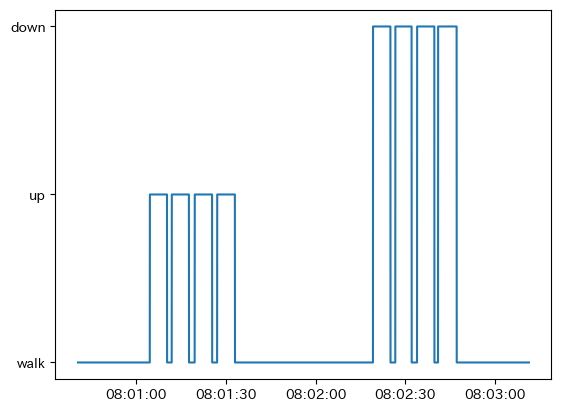

In [10]:
# 前後のposition_yの差分を取得
for i in range(len(walk_to_stair)):
    y_diff = (
        free_walk.df["position_y"][stair_to_walk[i]]
        - free_walk.df["position_y"][walk_to_stair[i]]
    )
    print(y_diff)
    # plus なら status を 'up' にする
    # walk_to_stair[i] から stair_to_walk[i] までの status 書き換える
    if y_diff > 0:
        free_walk.df.loc[walk_to_stair[i] : stair_to_walk[i], "status"] = "up"
    # minus なら status を 'down' にする
    # walk_to_stair[i] から stair_to_walk[i] までの status 書き換える
    elif y_diff < 0:
        free_walk.df.loc[walk_to_stair[i] : stair_to_walk[i], "status"] = "down"

# plot
plt.plot(free_walk.df["time"], free_walk.df["status"])
plt.show()

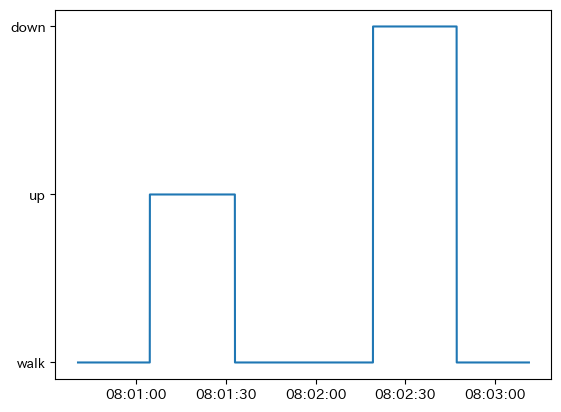

In [11]:
# stair_to_walk と次の stair_to_walk の値に変化がない場合はその status を前の status にする
free_walk.df["stair_status"] = free_walk.df["status"]
for i in range(len(stair_to_walk) - 1):
    if free_walk.df['stair_status'][stair_to_walk[i]] == free_walk.df['stair_status'][stair_to_walk[i+1]]:
        free_walk.df.loc[stair_to_walk[i]:stair_to_walk[i+1], 'stair_status'] = free_walk.df['stair_status'][stair_to_walk[i]]

plt.plot(free_walk.df['time'], free_walk.df['stair_status'])
plt.show()

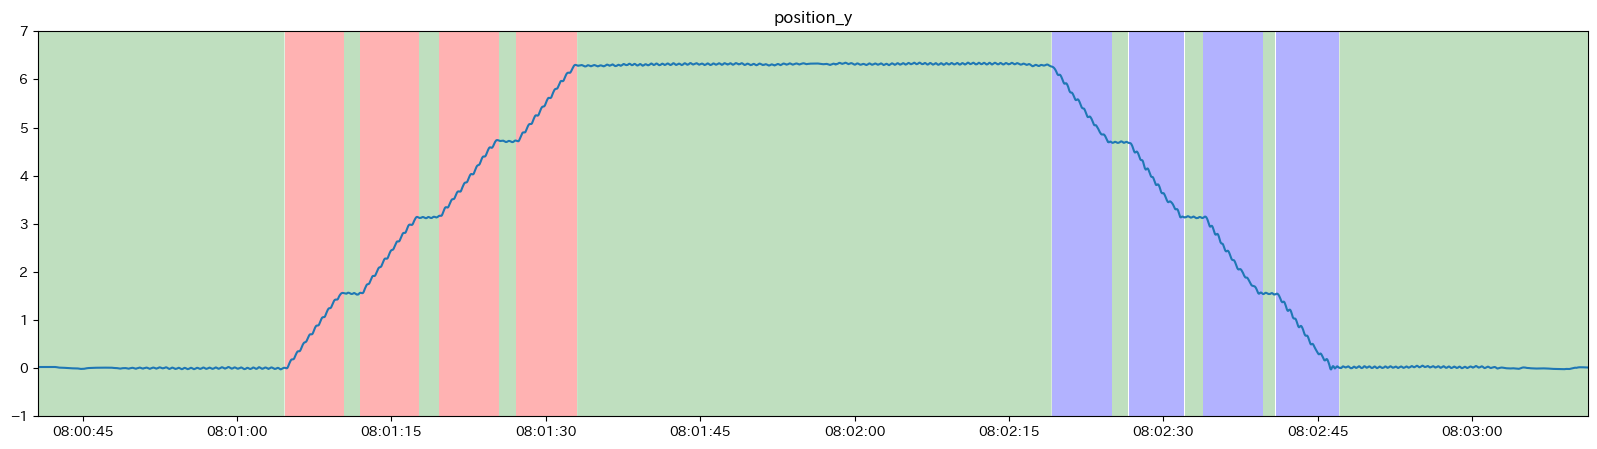

In [12]:
# positon_y と status は背景に表示する
fig = plt.figure(figsize=(20, 5))
plt.title("position_y")
plt.plot(free_walk.df["time"], free_walk.df["position_y"])
plt.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "up",
    facecolor="red",
    alpha=0.3,
)
plt.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "down",
    facecolor="blue",
    alpha=0.3,
)
plt.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "walk",
    facecolor="green",
    alpha=0.25,
)
plt.ylim(-1, 7)
plt.xlim(free_walk.df["time"][0], free_walk.df["time"][len(free_walk.df) - 1])
plt.show()

## status が walk のときの歩数をとる


In [13]:
# peakを取得する
# status が walk 以外のときの velocity_y を 0 にする
free_walk.df["velocity_walk_y"] = free_walk.df["velocity_y"].where(
    free_walk.df["status"] == "walk", 0
)

# ローパスフィルタ
free_walk.df["velocity_walk_low_y"] = (
    free_walk.df["velocity_walk_y"].rolling(int(filter_num / 4), center=True).mean()
)

peak, _ = find_peaks(free_walk.df["velocity_walk_low_y"], distance=22, height=0.01)

peak_walk_df = pd.DataFrame()
peak_walk_df["time"] = free_walk.df["time"]

# indexの初期値を取得する
peak_walk_first = free_walk.df.index[0]
# peakに初期値を足す
peak = peak + peak_walk_first
# peakの時間を取得する
peak_walk_time = free_walk.df["time"][peak]

# 階段を登っているか、平面を歩いているかを判定する
# peakのときのvelocity_yの値が0.2を超えていたら階段を登っていると判定する、それ以外のときは平面
peak_walk_df["status"] = "none"
for i in range(len(peak)):
    if free_walk.df["velocity_y"][peak[i]] > 0.01:
        peak_walk_df["status"][peak[i]] = "walk"
    else:
        peak_walk_df["status"][peak[i]] = "none"

# peak_dfからstatusがnoneの行を削除する
# peak_df = peak_df[peak_df['status'] != 'none']

# 階段を登る、平面を歩くを判定する
peak_walk_df = peak_walk_df[peak_walk_df["status"] == "walk"]

# それぞれのindexをリストに
peak_walks = [index for index in peak_walk_df.index]

# numpyに変換する
peak_walk_np = np.array(peak_walks)

peak_walk_time = free_walk.df["time"][peak_walk_np]

/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_17661/656998021.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_walk_df["status"][peak[i]] = "walk"
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_17661/656998021.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_walk_df["status"][peak[i]] = "walk"
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_17661/656998021.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

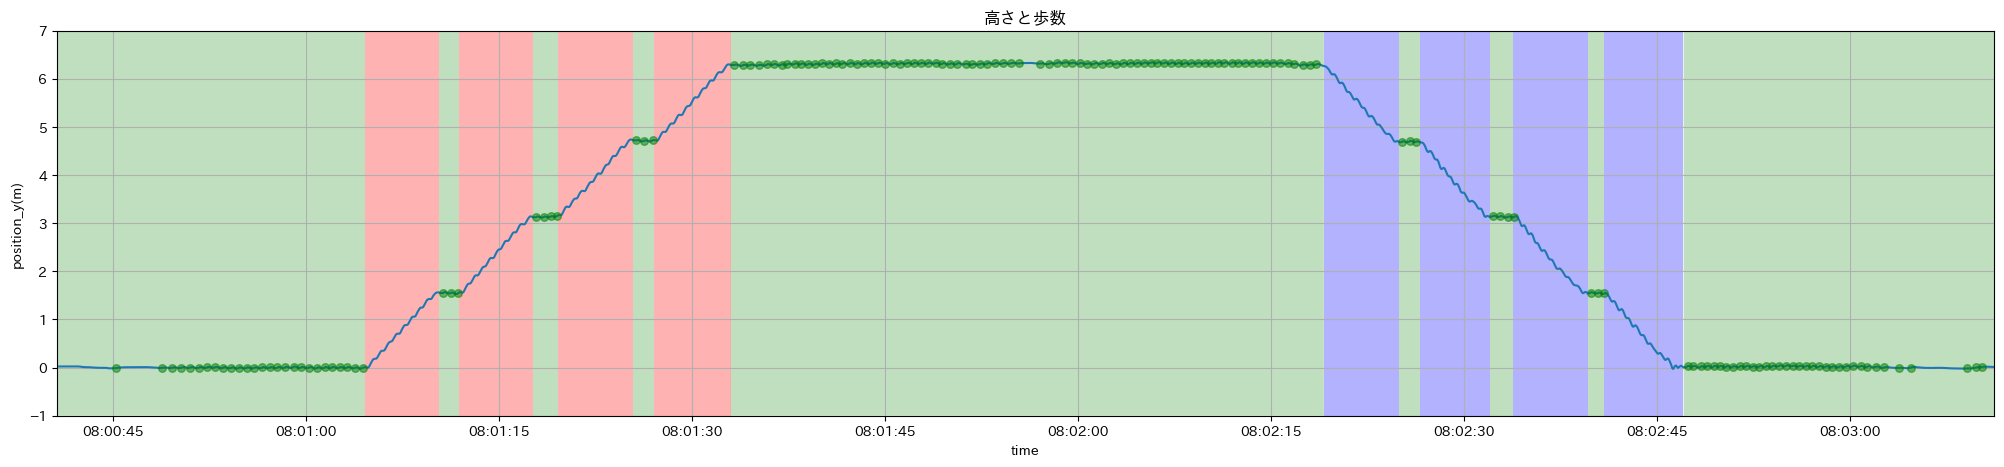

In [14]:
# position_pro_yとpositionのplot
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(free_walk.df["time"], free_walk.df["position_y"])
# 後ろを全体で塗る
ax.scatter(
    peak_walk_time,
    free_walk.df["position_y"][peak_walk_np],
    s=30,
    color="green",
    zorder=2,
    alpha=0.5,
)
ax.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "up",
    facecolor="red",
    alpha=0.3,
)
ax.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "down",
    facecolor="blue",
    alpha=0.3,
)
ax.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "walk",
    facecolor="green",
    alpha=0.25,
)
ax.set_title("高さと歩数")
ax.set_xlabel("time")
ax.set_ylabel("position_y(m)")
ax.set_ylim(-1, 7)
ax.set_xlim(free_walk.df["time"][0], free_walk.df["time"][len(free_walk.df) - 1])
ax.grid()
plt.show()

In [15]:
# peakを取得する
# status が walk 以外のときの velocity_y を 0 にする
free_walk.df["velocity_up_y"] = free_walk.df["velocity_y"].where(
    free_walk.df["status"] == "up", 0
)

# ローパスフィルタ
free_walk.df["velocity_up_low_y"] = (
    free_walk.df["velocity_up_y"].rolling(int(filter_num / 4), center=True).mean()
)

peak, _ = find_peaks(free_walk.df["velocity_up_low_y"], distance=22, height=0.01)

peak_up_df = pd.DataFrame()
peak_up_df["time"] = free_walk.df["time"]

# indexの初期値を取得する
peak_up_first = free_walk.df.index[0]
# peakに初期値を足す
peak = peak + peak_up_first
# peakの時間を取得する
peak_up_time = free_walk.df["time"][peak]

# 階段を登っているか、平面を歩いているかを判定する
# peakのときのvelocity_yの値が0.2を超えていたら階段を登っていると判定する、それ以外のときは平面
peak_up_df["status"] = "none"
for i in range(len(peak)):
    if free_walk.df["velocity_y"][peak[i]] > 0.3:
        peak_up_df["status"][peak[i]] = "up"
    else:
        peak_up_df["status"][peak[i]] = "none"

# 階段を登る、平面を歩くを判定する
peak_up_df = peak_up_df[peak_up_df["status"] == "up"]

# それぞれのindexをリストに
peak_ups = [index for index in peak_up_df.index]

# numpyに変換する
peak_up_np = np.array(peak_ups)

peak_up_time = free_walk.df["time"][peak_up_np]

/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_17661/1331023911.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_up_df["status"][peak[i]] = "up"
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_17661/1331023911.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_up_df["status"][peak[i]] = "up"
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_17661/1331023911.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

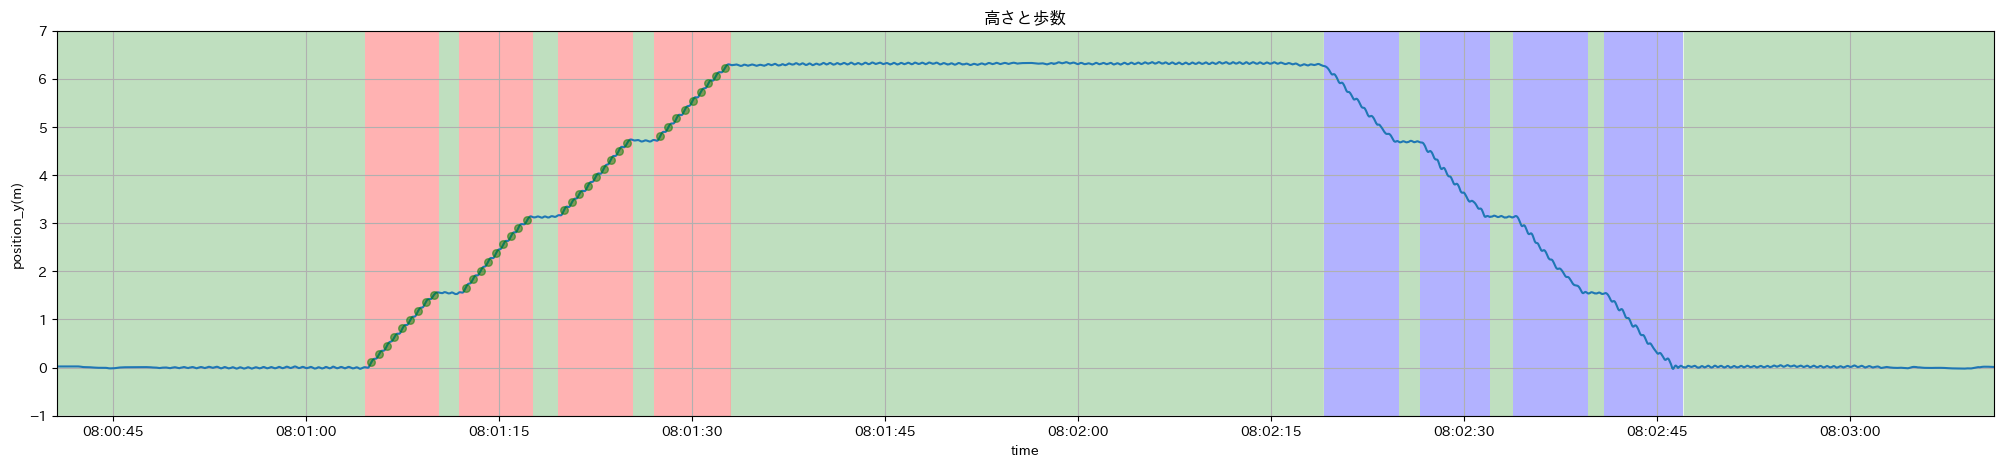

In [16]:
# position_pro_yとpositionのplot
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(free_walk.df["time"], free_walk.df["position_y"])
# 後ろを全体で塗る
ax.scatter(
    peak_up_time,
    free_walk.df["position_y"][peak_up_np],
    s=30,
    color="green",
    zorder=2,
    alpha=0.5,
)
ax.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "up",
    facecolor="red",
    alpha=0.3,
)
ax.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "down",
    facecolor="blue",
    alpha=0.3,
)
ax.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "walk",
    facecolor="green",
    alpha=0.25,
)
ax.set_title("高さと歩数")
ax.set_xlabel("time")
ax.set_ylabel("position_y(m)")
ax.set_ylim(-1, 7)
ax.set_xlim(free_walk.df["time"][0], free_walk.df["time"][len(free_walk.df) - 1])
ax.grid()
plt.show()

In [17]:
# peakを取得する

# velocity_yを反転させる
free_walk.reverse("velocity")
# status が walk 以外のときの velocity_y を 0 にする
free_walk.df["velocity_down_y"] = free_walk.df["velocity_reverse_y"].where(
    free_walk.df["status"] == "down", 0
)
# ローパスフィルタ
free_walk.df["velocity_down_low_y"] = (
    free_walk.df["velocity_down_y"].rolling(int(filter_num / 4), center=True).mean()
)

peak, _ = find_peaks(free_walk.df["velocity_down_low_y"], distance=22, height=0.01)

peak_down_df = pd.DataFrame()
peak_down_df["time"] = free_walk.df["time"]

# indexの初期値を取得する
peak_down_first = free_walk.df.index[0]
# peakに初期値を足す
peak = peak + peak_down_first
# peakの時間を取得する
peak_down_time = free_walk.df["time"][peak]

# 階段を登っているか、平面を歩いているかを判定する
# peakのときのvelocity_yの値が0.2を超えていたら階段を登っていると判定する、それ以外のときは平面
peak_down_df["status"] = "none"
for i in range(len(peak)):
    if free_walk.df["velocity_reverse_y"][peak[i]] > 0.3:
        peak_down_df["status"][peak[i]] = "down"
    else:
        peak_down_df["status"][peak[i]] = "none"

# 階段を登る、平面を歩くを判定する
peak_down_df = peak_down_df[peak_down_df["status"] == "down"]

# それぞれのindexをリストに
peak_downs = [index for index in peak_down_df.index]

# numpyに変換する
peak_down_np = np.array(peak_downs)

peak_down_time = free_walk.df["time"][peak_down_np]

/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_17661/2543704776.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_down_df["status"][peak[i]] = "down"
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_17661/2543704776.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_down_df["status"][peak[i]] = "down"
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_17661/2543704776.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

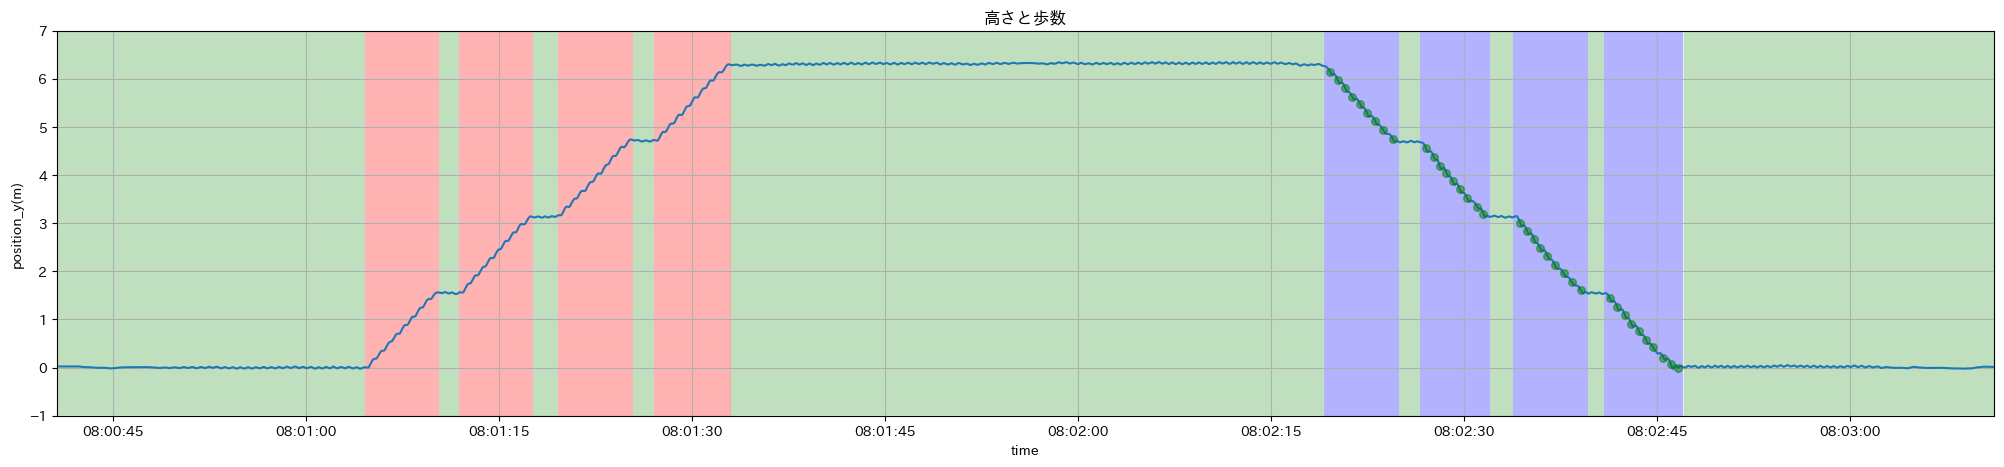

In [18]:
# position_pro_yとpositionのplot
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(free_walk.df["time"], free_walk.df["position_y"])
# 後ろを全体で塗る
ax.scatter(
    peak_down_time,
    free_walk.df["position_y"][peak_down_np],
    s=30,
    color="green",
    zorder=2,
    alpha=0.5,
)
ax.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "up",
    facecolor="red",
    alpha=0.3,
)
ax.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "down",
    facecolor="blue",
    alpha=0.3,
)
ax.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "walk",
    facecolor="green",
    alpha=0.25,
)
ax.set_title("高さと歩数")
ax.set_xlabel("time")
ax.set_ylabel("position_y(m)")
ax.set_ylim(-1, 7)
ax.set_xlim(free_walk.df["time"][0], free_walk.df["time"][len(free_walk.df) - 1])
ax.grid()
plt.show()

In [19]:
# 時系列順にpeakを結合する
peak_step_df = pd.concat([peak_walk_df, peak_up_df, peak_down_df])
peak_step_df = peak_step_df.sort_values('time')
print(peak_step_df)

                               time status
330   2023-11-27 08:00:45.284000000   walk
584   2023-11-27 08:00:48.811000064   walk
644   2023-11-27 08:00:49.644000000   walk
695   2023-11-27 08:00:50.352000000   walk
745   2023-11-27 08:00:51.046999808   walk
...                             ...    ...
10303 2023-11-27 08:03:03.842999808   walk
10367 2023-11-27 08:03:04.731000064   walk
10680 2023-11-27 08:03:09.128000000   walk
10731 2023-11-27 08:03:09.829999872   walk
10764 2023-11-27 08:03:10.283000064   walk

[235 rows x 2 columns]


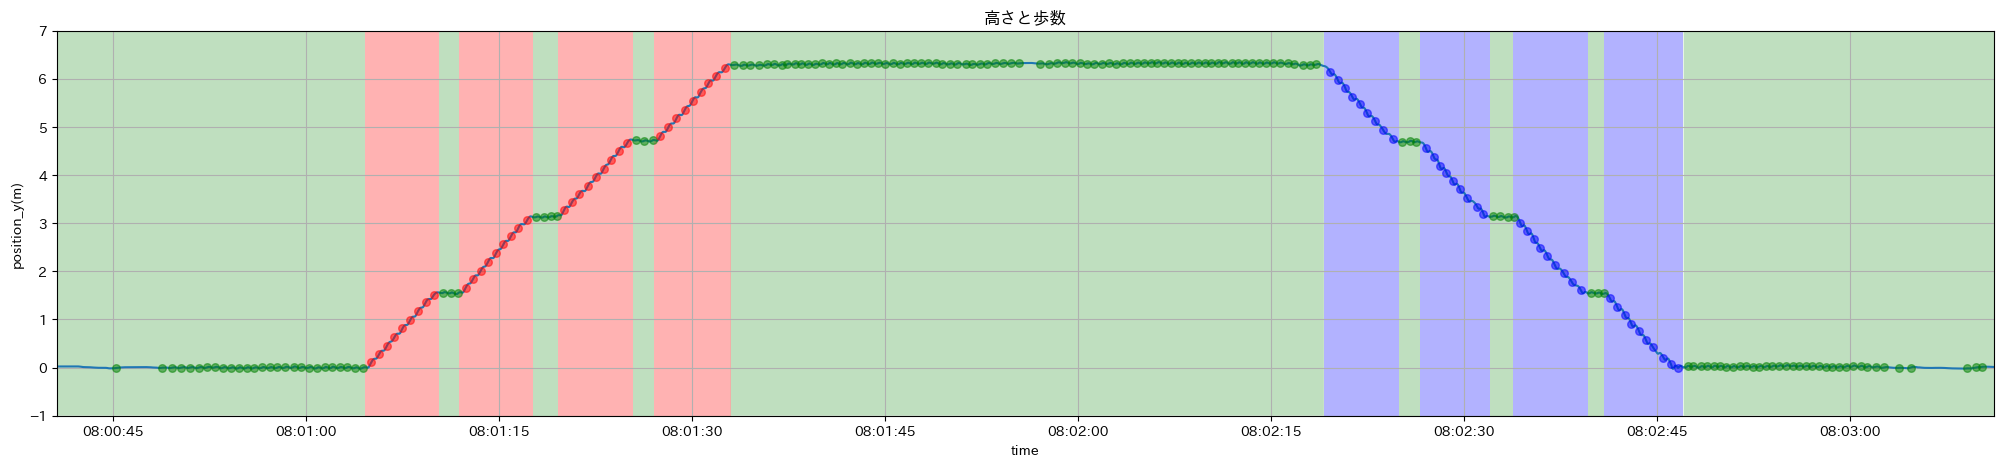

In [20]:
# positionに合わせて peak をplot
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(free_walk.df["time"], free_walk.df["position_y"])
# 後ろを全体で塗る
# status が walk の peak を plot
ax.scatter(
    peak_walk_df["time"],
    free_walk.df["position_y"][peak_walk_df.index],
    s=30,
    color="green",
    zorder=2,
    alpha=0.5,
)
# status が up の peak を plot
ax.scatter(
    peak_up_df["time"],
    free_walk.df["position_y"][peak_up_df.index],
    s=30,
    color="red",
    zorder=2,
    alpha=0.5,
)
# status が down の peak を plot
ax.scatter(
    peak_down_df["time"],
    free_walk.df["position_y"][peak_down_df.index],
    s=30,
    color="blue",
    zorder=2,
    alpha=0.5,
)
ax.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "up",
    facecolor="red",
    alpha=0.3,
)
ax.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "down",
    facecolor="blue",
    alpha=0.3,
)
ax.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "walk",
    facecolor="green",
    alpha=0.25,
)
ax.set_title("高さと歩数")
ax.set_xlabel("time")
ax.set_ylabel("position_y(m)")
ax.set_ylim(-1, 7)
ax.set_xlim(free_walk.df["time"][0], free_walk.df["time"][len(free_walk.df) - 1])
ax.grid()
plt.show()

## 階段の段数の補正


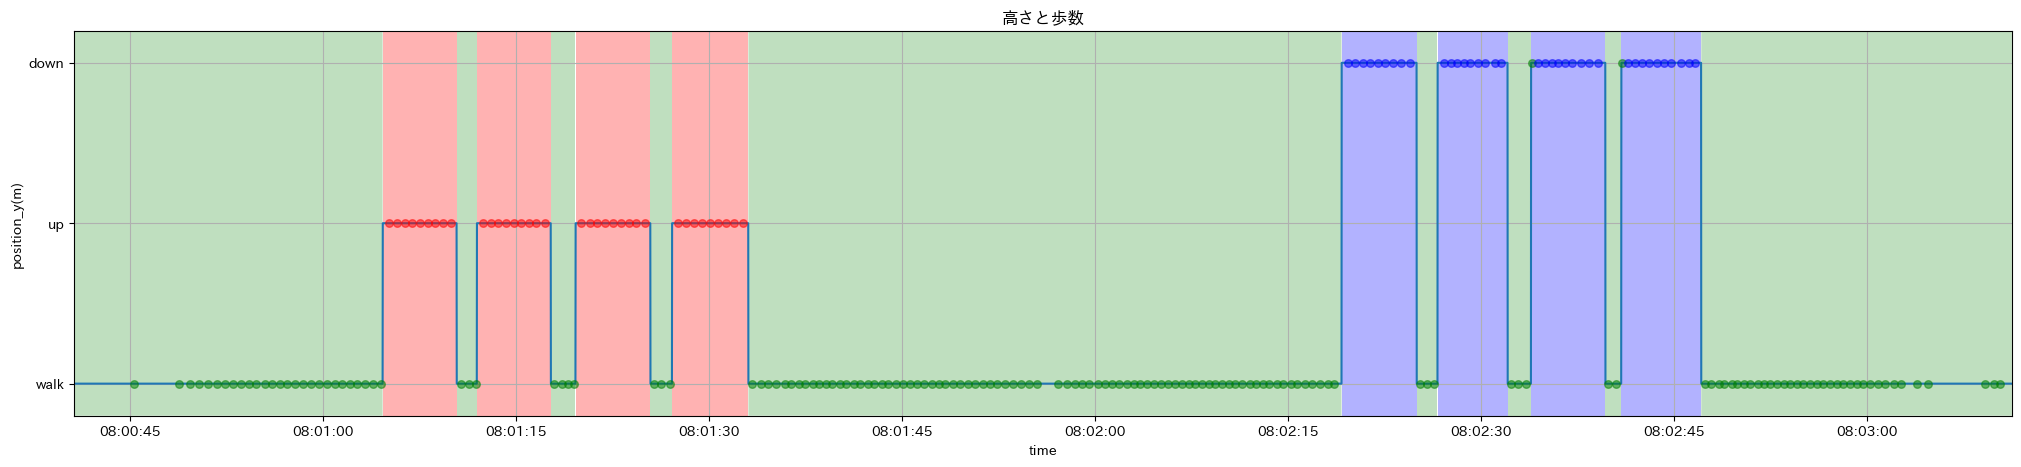

In [21]:
# status と peak を plot
top = 2.2
bottom = -0.2

fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(free_walk.df["time"], free_walk.df["status"])
# 後ろを全体で塗る
# status が walk の peak を plot
ax.scatter(
    peak_walk_df["time"],
    free_walk.df["status"][peak_walk_df.index],
    s=30,
    color="green",
    zorder=2,
    alpha=0.5,
)
# status が up の peak を plot
ax.scatter(
    peak_up_df["time"],
    free_walk.df["status"][peak_up_df.index],
    s=30,
    color="red",
    zorder=2,
    alpha=0.5,
)
# status が down の peak を plot
ax.scatter(
    peak_down_df["time"],
    free_walk.df["status"][peak_down_df.index],
    s=30,
    color="blue",
    zorder=2,
    alpha=0.5,
)
ax.fill_between(
    free_walk.df["time"],
    bottom,
    top,
    where=free_walk.df["status"] == "up",
    facecolor="red",
    alpha=0.3,
)
ax.fill_between(
    free_walk.df["time"],
    bottom,
    top,
    where=free_walk.df["status"] == "down",
    facecolor="blue",
    alpha=0.3,
)
ax.fill_between(
    free_walk.df["time"],
    bottom,
    top,
    where=free_walk.df["status"] == "walk",
    facecolor="green",
    alpha=0.25,
)
ax.set_title("高さと歩数")
ax.set_xlabel("time")
ax.set_ylabel("position_y(m)")
ax.set_ylim(bottom, top)
ax.set_xlim(free_walk.df["time"][0], free_walk.df["time"][len(free_walk.df) - 1])
ax.grid()
plt.show()

In [22]:
steps = pd.DataFrame(columns=["status", "number", "step"])


# 数える関数
def len_step(steps, status, peaks):
    counter = 0
    for i in peaks:
        # status, 何番目の階段か, 何段かを追加する
        tmp = pd.DataFrame({"status": [status], "number": [counter], "step": [len(i)]})
        steps = pd.concat([steps, tmp], ignore_index=True)
        counter += 1
    return steps


def remove_walk_peak(peak):
    global peak_walk_df
    # peak_walk_df の中で peak にもっとも近い index をもつものを削除する
    for i in peak:
        # peak_walk_df の中で peak にもっとも近い index をもつものを削除する
        peak_walk_df.drop(
            peak_walk_df.index[(peak_walk_df.index - i).abs().argsort()[0]],
            inplace=True,
        )


def insert_walk_peak(peak):
    global peak_walk_df
    peak_time = free_walk.df["time"][peak]
    tmp = pd.DataFrame({"time": [peak_time], "status": ["walk"]})
    # peak_walk_df の中に peak を追加する
    peak_walk_df = pd.concat([peak_walk_df, tmp])
    # 並べ替え
    peak_walk_df = peak_walk_df.sort_values("time")
    # free_walk.df から time を参照して index を取得する
    peak_walk_df.index = free_walk.df.index[
        free_walk.df["time"].isin(peak_walk_df["time"])
    ]

In [23]:
ups = []
tmp = []
count = 0
# status が up で連続している区間を取得する
for i in free_walk.df.index:
    try:
        before_status = free_walk.df["status"][i - 1]
    except:
        before_status = "walk"
    status = free_walk.df["status"][i]
    if status == "up" and before_status == "walk":
        tmp.append(i)
    elif before_status == "up" and status == "walk":
        tmp.append(i)
        ups.append(tmp)
        tmp = []

# up が連続している区間の中の peak を取得する
peak_ups = []
for up in ups:
    tmp = []
    for peak in peak_up_df.index:
        if up[0] < peak and peak < up[1]:
            tmp.append(peak)
    peak_ups.append(tmp)
# 数える
steps = len_step(steps, "up", peak_ups)

In [24]:
downs = []
tmp = []
count = 0
# status が down で連続している区間を取得する
for i in free_walk.df.index:
    try:
        before_status = free_walk.df["status"][i - 1]
    except:
        before_status = "walk"
    status = free_walk.df["status"][i]
    if status == "down" and before_status == "walk":
        tmp.append(i)
    elif before_status == "down" and status == "walk":
        tmp.append(i)
        downs.append(tmp)
        tmp = []

# down が連続している区間の中の peak を取得する
peak_downs = []
for down in downs:
    tmp = []
    for peak in peak_down_df.index:
        if down[0] < peak and peak < down[1]:
            tmp.append(peak)
    peak_downs.append(tmp)

# 数える
steps = len_step(steps, "down", peak_downs)

In [25]:
# 誤った値を修正する関数
def process_peaks(step, peak, start, end):
    first = peak[0]
    last = peak[len(peak) - 1]
    first_diff = abs(start - first)
    last_diff = abs(end - last)
    if step > step_median:
        if first_diff > last_diff:
            peak.remove(first)
            # peak_walk_df に first を追加する
            insert_walk_peak(first)
        else:
            peak.remove(last)
            # peak_walk_df に last を追加する
            insert_walk_peak(last)
    else:
        # peak_walk_df でそのpeakの値から一番近い値を探す
        if first_diff > last_diff:
            peak.append(first)
            remove_walk_peak(first)
        else:
            peak.append(last)
            remove_walk_peak(last)
    return peak


def collect_peaks(step):
    status = steps["status"][i]
    number = steps["number"][i]
    if status == "up":
        start = ups[number][0]
        end = ups[number][1]
        peak_ups[number] = process_peaks(step, peak_ups[number], start, end)
    elif status == "down":
        start = downs[number][0]
        end = downs[number][1]
        peak_downs[number] = process_peaks(step, peak_downs[number], start, end)
    return peak_ups, peak_downs

In [26]:
try:
    # 中央値を取得する
    step_median = steps["step"].median()
    # step_median に適合しないものを探す
    while True:
        for i in steps.index:
            step = steps["step"][i]
            if step == step_median:
                continue
            peak_ups, peak_downs = collect_peaks(step)
            status = steps["status"][i]
            if status == "up":
                steps.loc[i, "step"] = len(peak_ups[steps["number"][i]])
            elif status == "down":
                steps.loc[i, "step"] = len(peak_downs[steps["number"][i]])
        step_median = steps["step"].median()
        if step_median == step:
            break
except:
    pass

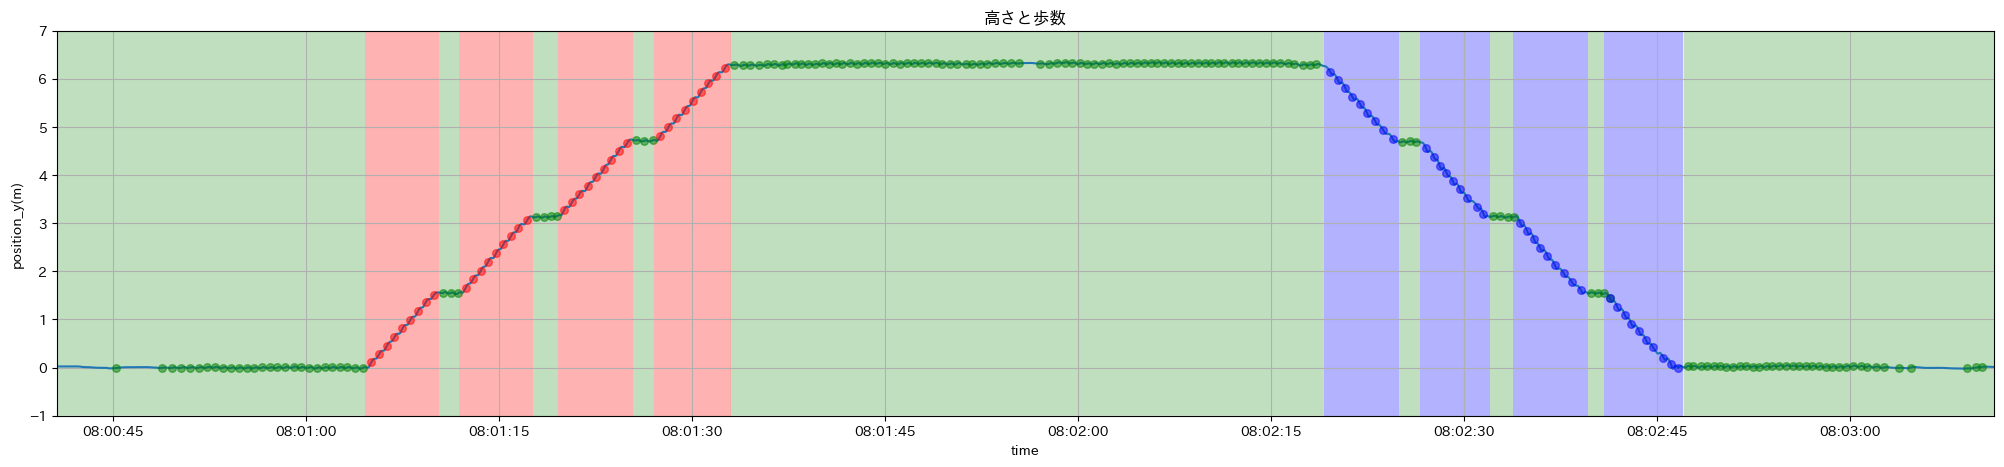

In [27]:
# positionに合わせて peak をplot
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(free_walk.df["time"], free_walk.df["position_y"])
# 後ろを全体で塗る
# status が walk の peak を plot
ax.scatter(
    peak_walk_df["time"],
    free_walk.df["position_y"][peak_walk_df.index],
    s=30,
    color="green",
    zorder=2,
    alpha=0.5,
)
# status が up の peak を plot
ax.scatter(
    peak_up_df["time"],
    free_walk.df["position_y"][peak_up_df.index],
    s=30,
    color="red",
    zorder=2,
    alpha=0.5,
)
# status が down の peak を plot
ax.scatter(
    peak_down_df["time"],
    free_walk.df["position_y"][peak_down_df.index],
    s=30,
    color="blue",
    zorder=2,
    alpha=0.5,
)
ax.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "up",
    facecolor="red",
    alpha=0.3,
)
ax.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "down",
    facecolor="blue",
    alpha=0.3,
)
ax.fill_between(
    free_walk.df["time"],
    -1,
    7,
    where=free_walk.df["status"] == "walk",
    facecolor="green",
    alpha=0.25,
)
ax.set_title("高さと歩数")
ax.set_xlabel("time")
ax.set_ylabel("position_y(m)")
ax.set_ylim(-1, 7)
ax.set_xlim(free_walk.df["time"][0], free_walk.df["time"][len(free_walk.df) - 1])
ax.grid()
plt.show()

## 踊り場の長さを取得


In [28]:
# up, down の連続する区間での stair → walk から walk → stair の歩数の平均を取得する
# up の連続する区間 ups
# down の連続する区間 downs

landings = []
for i in range(len(ups) - 1):
    tmp = []
    tmp.append(ups[i][1])
    tmp.append(ups[i + 1][0])
    landings.append(tmp)
    tmp = []
for i in range(len(downs) - 1):
    tmp = []
    tmp.append(downs[i][1])
    tmp.append(downs[i + 1][0])
    landings.append(tmp)
    tmp = []

In [29]:
try:
    step_counts = 0
    for landing in landings:
        # landing[0]からlandring[1]までのindexの中で peak_walk_df が持つ peakの数 を取得する
        for peak in peak_walk_df.index:
            if landing[0] < peak and peak < landing[1]:
                step_counts += 1

    # 平均の歩数を取得する(四捨五入)
    step_counts_mean = int(step_counts / len(landings))

    print(step_counts_mean)
except:
    pass

3


## 階段の踊り場の歩数を補正

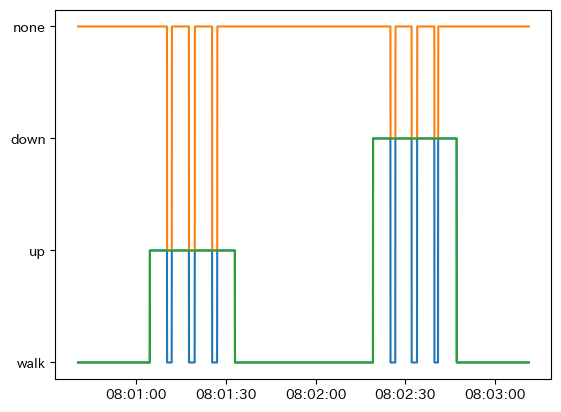

In [30]:
# 踊り場区間での歩数を補正
# 踊り場区間の歩数を取得する
i = 0
free_walk.df['landing_status'] = 'none'
for p in free_walk.df.index:
    # status が walk かつ stair_status が up のとき 
    if free_walk.df['status'][p] == 'walk' and free_walk.df['stair_status'][p] == 'up':
        # landing_status を 'up' にする
        free_walk.df.loc[p:p+step_counts_mean, 'landing_status'] = 'up'
    # status が walk かつ stair_status が down のとき
    elif free_walk.df['status'][p] == 'walk' and free_walk.df['stair_status'][p] == 'down':
        # landing_status を 'down' にする
        free_walk.df.loc[p:p+step_counts_mean, 'landing_status'] = 'down'

plt.plot(free_walk.df['time'], free_walk.df['status'])
plt.plot(free_walk.df['time'], free_walk.df['landing_status'])
plt.plot(free_walk.df['time'], free_walk.df['stair_status'])
plt.show()

In [31]:
# 中央値を取得する
# landing_status が up で連続している区間を取得する
ups = []
tmp = []
count = 0
for i in free_walk.df.index:
    try:
        before_status = free_walk.df["landing_status"][i - 1]
    except:
        before_status = "none"
    status = free_walk.df["landing_status"][i]
    if status == "up" and before_status == "none":
        tmp.append(i)
    elif before_status == "up" and status == "none":
        tmp.append(i)
        ups.append(tmp)
        tmp = []

print(ups)
# up が連続している区間の中の peak を取得する
peak_ups = []
for up in ups:
    tmp = []
    for peak in peak_step_df.index:
        if up[0] < peak and peak < up[1]:
            tmp.append(peak)
    peak_ups.append(tmp)
print(peak_ups)

# 最頻値を取得する
mode = 0
for i in range(len(peak_ups)):
    mode = max(mode, len(peak_ups[i]))
print(mode)

[[2135, 2251], [2662, 2803], [3219, 3343]]
[[2159, 2202, 2243], [2679, 2722, 2759, 2792], [3239, 3280, 3329]]
4


In [32]:
# mode に足りていないpeak_upsを取得する
print(peak_ups)
for i in range(len(peak_ups)):
    if len(peak_ups[i]) < mode:
        start = ups[i][0]
        end = ups[i][1]
        print(f'start: {start}, end: {end}')
        # peak_ups[i]のでstartとendに近い値を取得する
        start_diff = abs(start - peak_ups[i][0])
        end_diff = abs(end - peak_ups[i][len(peak_ups[i]) - 1])
        print(f'start_diff: {start_diff}, end_diff: {end_diff}')
        if start_diff > end_diff:
            peak_ups[i].append(start)
        else:
            peak_ups[i].append(end)
        # peak_ups[i]を並べ替える
        peak_ups[i].sort()
print(peak_ups)

[[2159, 2202, 2243], [2679, 2722, 2759, 2792], [3239, 3280, 3329]]
start: 2135, end: 2251
start_diff: 24, end_diff: 8
start: 3219, end: 3343
start_diff: 20, end_diff: 14
[[2135, 2159, 2202, 2243], [2679, 2722, 2759, 2792], [3219, 3239, 3280, 3329]]


## 回転量をとる


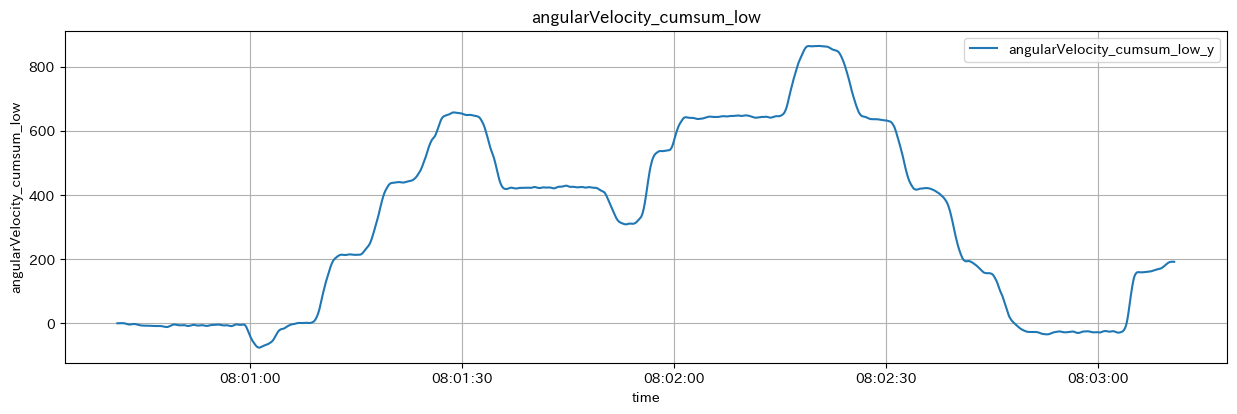

In [33]:
free_walk.cumsum("angularVelocity")
free_walk.low_filter("angularVelocity_cumsum", filter_num)
free_walk.plot("angularVelocity_cumsum", "low", "y")
# print(free_walk.df.columns)
angularVelocity = pd.DataFrame()
angularVelocity['cumsum_low_x_y'] = free_walk.df["angularVelocity_cumsum_low_x"]  + free_walk.df["angularVelocity_cumsum_low_y"]
angularVelocity['cumsum_low_x_z'] = free_walk.df["angularVelocity_cumsum_low_x"]  + free_walk.df["angularVelocity_cumsum_low_z"]

Index([2134, 2661, 3218, 3766, 7506, 8015, 8562, 9096], dtype='int64')
[[0, 0], [0.4974989833248342, -0.04994758843784449], [0.995673034892369, -0.09263967605120957], [1.494211918645523, -0.13083629090330487], [1.9927523124073883, -0.169013192136437], [2.489707389308165, -0.2241099392504285], [2.988340523888289, -0.2610558063914207], [3.486372542688865, -0.30537406729392635], [3.9846561377954295, -0.3467680142871477], [4.481836815759537, -0.3997904006833748], [4.979959812307184, -0.4430741194514309], [5.478789698426704, -0.47726102796897973], [5.978081879834119, -0.5038564709136835], [6.476265070086323, -0.5464417846983189], [6.9746056549917865, -0.5871438907381861], [7.471071968662087, -0.6464835856364822], [7.970157785735354, -0.6767052202102416], [8.469082571944249, -0.7094780398388353], [8.96844400097913, -0.7347399319342636], [9.44135924034157, -0.8970703861896713], [9.807840633249226, -1.2372047547154985], [10.073375440828, -1.6608688503904838], [10.332230737409468, -2.0886467547

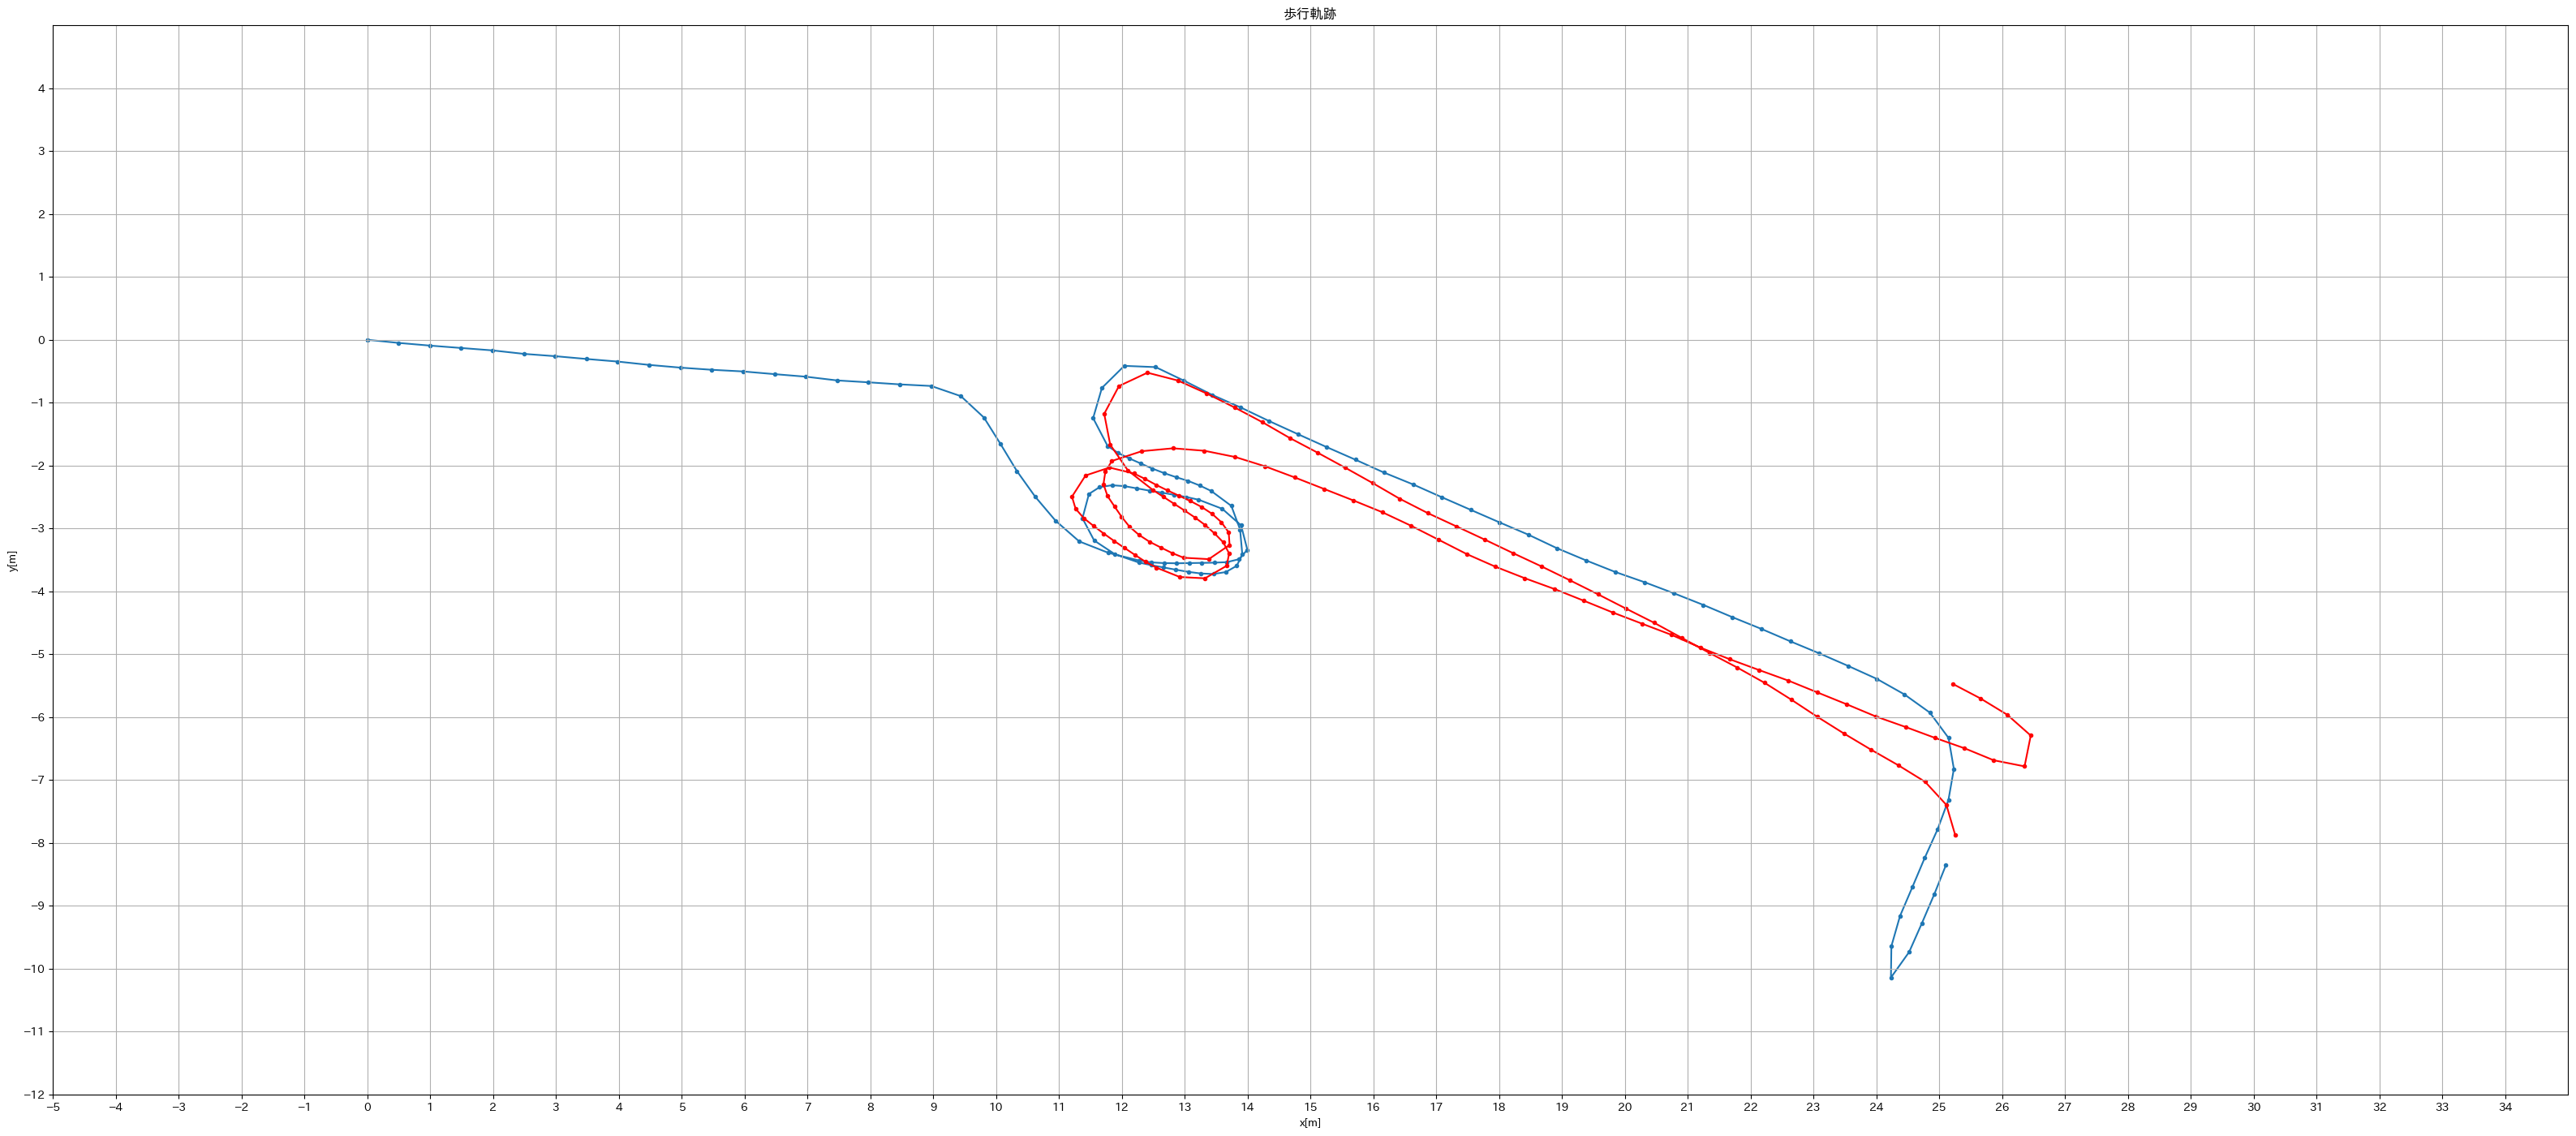

In [38]:
# 軌跡を描く
# 補正値
shift_num = 72.1
print(stair_to_walk)
step_lange = 0.5
step_lange_land = 0.4
step_lange_stair = 0.2
x,y = 0,0
i = 0
point = [[0, 0]]
for p in peak_step_df.index:
    # p が踊り場のときはstep_lange_lenにする
    # walk_to_stair[i] から stair_to_walk[i] までのときは step_lange_len にする
    if free_walk.df['landing_status'][p] != 'none':
        x = step_lange_land * np.cos(free_walk.df['angularVelocity_cumsum_low_y'][p]/shift_num) + point[-1][0]
        y = step_lange_land * np.sin(free_walk.df['angularVelocity_cumsum_low_y'][p]/shift_num) + point[-1][1]
    elif free_walk.df['status'][p] != 'walk':
        x = step_lange_stair * np.cos(free_walk.df['angularVelocity_cumsum_low_y'][p]/shift_num) + point[-1][0]
        y = step_lange_stair * np.sin(free_walk.df['angularVelocity_cumsum_low_y'][p]/shift_num) + point[-1][1]
    else:
        x = step_lange * np.cos(free_walk.df['angularVelocity_cumsum_low_y'][p]/shift_num) + point[-1][0]
        y = step_lange * np.sin(free_walk.df['angularVelocity_cumsum_low_y'][p]/shift_num) + point[-1][1]
    

    point.append([x, y])

print(point)
# pointを前半分だけ取得する
# pointを前半分だけ取得する
point_half = pd.DataFrame(data=point[:len(point)//2], columns=['x', 'y'])
point_after = pd.DataFrame(data=point[len(point)//2:], columns=['x', 'y'])

point = pd.DataFrame(data=point, columns=['x', 'y'])

point['x'] = point['x'] - point['x'][0]
point['y'] = point['y'] - point['y'][0]

size = ((-5, 35), (-12, 5))
fig = plt.figure(figsize=(40, 40))

# plt.plot(point['x'], point['y'], '.-', label='推定', zorder=1)
plt.plot(point_half['x'], point_half['y'], '.-', label='推定', zorder=1)
plt.plot(point_after['x'], point_after['y'], 'r.-', label='推定', zorder=1)

# 軸を揃える
plt.gca().set_aspect('equal', adjustable='box')

plt.title('歩行軌跡')
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.xticks(np.arange(size[0][0], size[0][1], 1))
plt.yticks(np.arange(size[1][0], size[1][1], 1))
plt.xlim(size[0][0], size[0][1])
plt.ylim(size[1][0], size[1][1])

plt.grid()
plt.show()

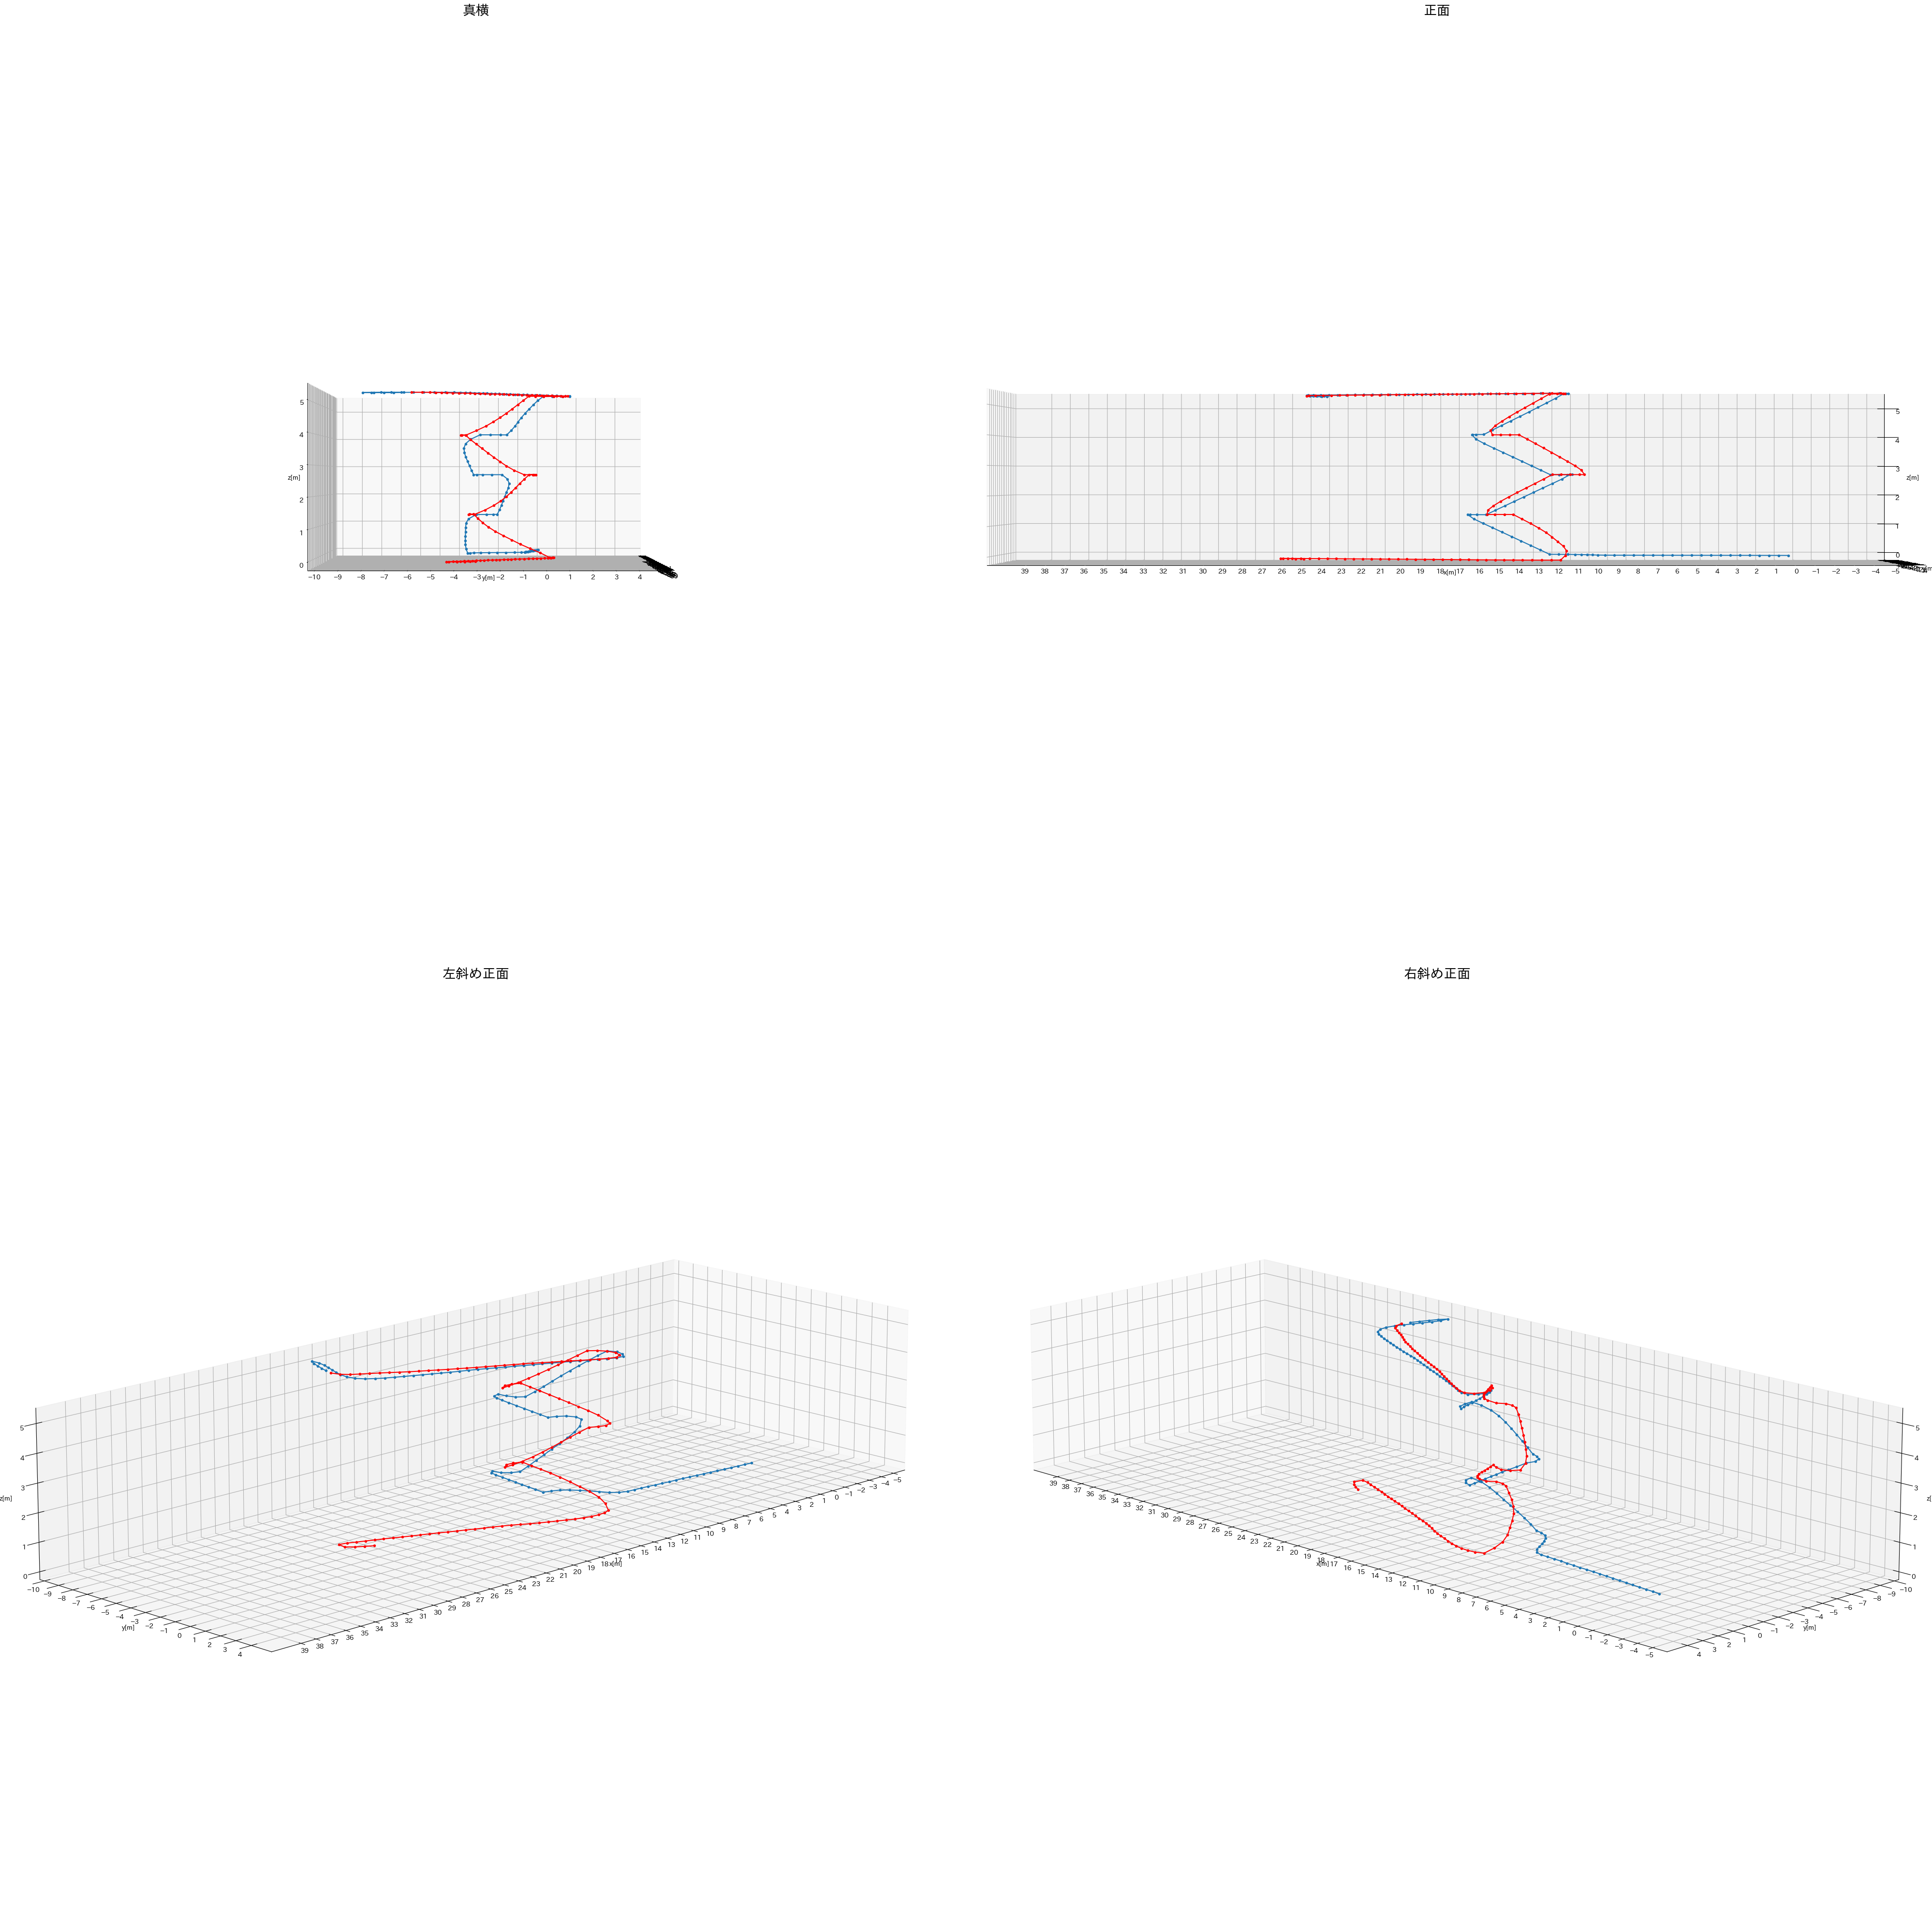

In [35]:
# 軌跡を描く
point = [[0, 0, 0]]
stair_length = 0.15
z = 0
for p in peak_step_df.index:
    x = step_lange * np.cos(free_walk.df['angularVelocity_cumsum_low_y'][p]/shift_num) + point[-1][0]
    y = step_lange * np.sin(free_walk.df['angularVelocity_cumsum_low_y'][p]/shift_num) + point[-1][1]
    # pがpeak_step_df.indexに含まれているときはzにstep_langeを足す
    if p in peak_up_df.index:
        z = stair_length + z
    elif p in peak_down_df.index:
        z = z - stair_length
    point.append([x, y, z])


# pointを前半分だけ取得する
point_half = point[:len(point)//2]
point_after = point[len(point)//2:]

point = pd.DataFrame(data=point, columns=['x', 'y', 'z'])
point_half = pd.DataFrame(data=point_half, columns=['x', 'y', 'z'])
point_after = pd.DataFrame(data=point_after, columns=['x', 'y', 'z'])


fig = plt.figure(figsize=(40, 40))

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    # ax.plot(point['x'], point['y'], point['z'], '.-', zorder=1)
    ax.plot(point_half['x'], point_half['y'], point_half['z'], '.-', zorder=1)
    ax.plot(point_after['x'], point_after['y'], point_after['z'], 'r.-', zorder=1)

    ax.set_aspect('equal', adjustable='box')

    if i == 1:
        i = 2
    elif i == 2:
        i = 1

    if i == 0:
        ax.set_title('真横', fontsize=20)
    elif i == 1:
        ax.set_title('左斜め正面', fontsize=20)
    elif i == 2:
        ax.set_title('正面', fontsize=20)
    elif i == 3:
        ax.set_title('右斜め正面', fontsize=20)
    ax.set_xlabel('x[m]')
    ax.set_ylabel('y[m]')
    ax.set_zlabel('z[m]')
    ax.set_xticks(np.arange(size[0][0], size[0][1], 1))
    ax.set_yticks(np.arange(size[1][0], size[1][1], 1))
    ax.set_xlim(size[0][0], size[0][1])
    ax.set_ylim(size[1][0], size[1][1])

    # 視野の調整
    if i ==  0 or i == 2:
        ax.view_init(azim=0 + i * 45, elev=0)
    else:
        ax.view_init(azim=0 + i * 45, elev=15)

plt.tight_layout()
plt.show()
